In [12]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch.nn.functional as F
from torchinfo import summary

In [13]:
df = pd.read_csv(r"C:\Users\hdgn5\OneDrive\Masaüstü\pytorch fundementals\ANN\Datasets\kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [14]:
deleted_colons = ["id" , "date"]

df = df.drop(columns=[col for col in deleted_colons if col in df.columns])

In [15]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [16]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [17]:
df.shape

(21613, 19)

<Axes: >

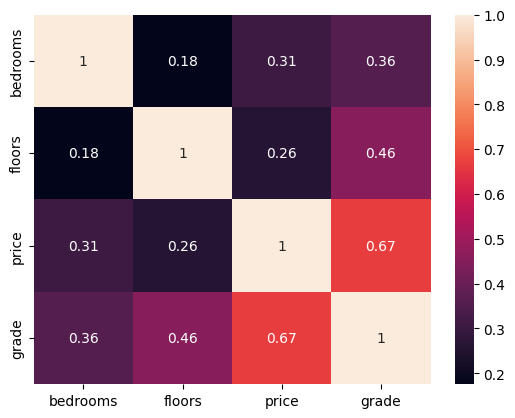

In [18]:
sns.heatmap(df[["bedrooms", "floors", "price","grade"]].corr(), annot=True)


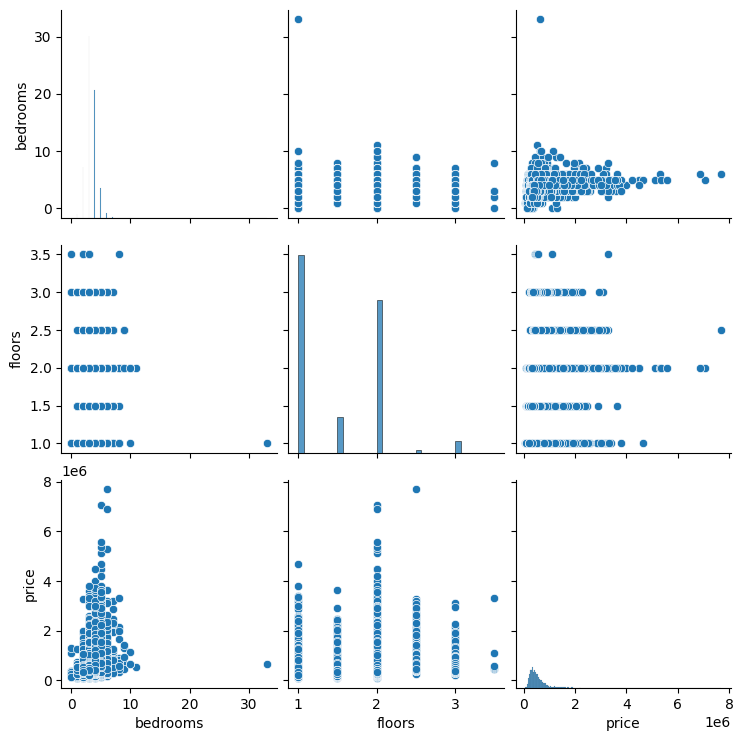

In [19]:
sns.pairplot(df[["bedrooms", "floors", "price"]])

In [20]:
x = df.drop("price" , axis=1).values
y = df["price"]

In [21]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
X_train = torch.tensor(X_train , dtype=torch.float32)
X_test = torch.tensor(X_test , dtype = torch.float32)

y_train = torch.tensor(y_train.values , dtype = torch.float32).view(-1,1)
y_test = torch.tensor(y_test.values, dtype = torch.float32).view(-1,1)

In [23]:
scaler_y = StandardScaler()
y_train_scaled = torch.tensor(scaler_y.fit_transform(y_train.numpy()), dtype=torch.float32)
y_test_scaled = torch.tensor(scaler_y.transform(y_test.numpy()), dtype=torch.float32)


In [24]:
train_dataset = TensorDataset(X_train, y_train_scaled)
test_dataset = TensorDataset(X_test, y_test_scaled)

In [25]:
train_loader = DataLoader(train_dataset , batch_size =32 , shuffle = True)
test_loader = DataLoader(test_dataset , batch_size=32 ,shuffle=False)

In [26]:
class ANN(nn.Module):
    def __init__(self, input_dim, hidden=[256,128,64,32], dropout=0.3, out_activation=None):
        super().__init__()
        self.layers = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        self.out_activation = out_activation  # torch.sigmoid, lambda x: torch.softmax(x, dim=1) veya None

        prev = input_dim
        for h in hidden:
            self.layers.append(nn.Linear(prev, h))
            self.bn.append(nn.BatchNorm1d(h))
            prev = h

        self.out = nn.Linear(prev, 1)
        self._init_weights()

    def _init_weights(self):
        for layer in [*self.layers, self.out]:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        res = x
        for i, l in enumerate(self.layers):
            x = l(x)
            x = self.bn[i](x)
            x = F.relu(x)
            x = self.dropout(x)

            if i % 2 == 1:
                if res.shape[1] != x.shape[1]:
                    res = F.pad(res, (0, x.shape[1]-res.shape[1]))
                x = x + res
                res = x

        x = self.out(x)
        if self.out_activation:
            x = self.out_activation(x)
        return x


In [27]:
model = ANN(input_dim=X_train.shape[1])
print(model)

ANN(
  (layers): ModuleList(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (bn): ModuleList(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [28]:
loss_fonk = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=1E-3 , weight_decay=1e-4 )
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min", factor=0.5 , patience=10)

In [29]:
summary(model, input_size= (128, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
ANN                                      [128, 1]                  --
├─ModuleList: 1-10                       --                        (recursive)
│    └─Linear: 2-1                       [128, 256]                4,864
├─ModuleList: 1-11                       --                        (recursive)
│    └─BatchNorm1d: 2-2                  [128, 256]                512
├─Dropout: 1-3                           [128, 256]                --
├─ModuleList: 1-10                       --                        (recursive)
│    └─Linear: 2-3                       [128, 128]                32,896
├─ModuleList: 1-11                       --                        (recursive)
│    └─BatchNorm1d: 2-4                  [128, 128]                256
├─Dropout: 1-6                           [128, 128]                --
├─ModuleList: 1-10                       --                        (recursive)
│    └─Linear: 2-5             

In [31]:
epoch_num = 20
train_loss = []
test_mse = []
test_r2 = []

for epoch in range(epoch_num):
    model.train()
    runn_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fonk(outputs, y_batch)
        loss.backward()
        optimizer.step()
        runn_loss += loss.item() * X_batch.size(0)

    epoch_loss = runn_loss / len(train_loader.dataset)
    train_loss.append(epoch_loss)
    scheduler.step(epoch_loss)

    model.eval()
    
    with torch.no_grad():
        y_pred = model(X_test)
        mse = ((y_pred - y_test_scaled) ** 2).mean().item()
        ss_res = ((y_test_scaled - y_pred) ** 2).sum()
        ss_tot = ((y_test_scaled - y_test_scaled.mean()) ** 2).sum()
        r2 = 1 - ss_res / ss_tot

        test_mse.append(mse)
        test_r2.append(r2.item())

    print(f"Epoch [{epoch+1}/{epoch_num}] | Loss: {epoch_loss:.4f} | Test MSE: {mse:.4f} | R2: {r2:.4f}")


Epoch [1/20] | Loss: 0.2667 | Test MSE: 0.2185 | R2: 0.8112
Epoch [2/20] | Loss: 0.2476 | Test MSE: 0.2128 | R2: 0.8161
Epoch [3/20] | Loss: 0.2320 | Test MSE: 0.2113 | R2: 0.8174
Epoch [4/20] | Loss: 0.2264 | Test MSE: 0.2033 | R2: 0.8243
Epoch [5/20] | Loss: 0.2133 | Test MSE: 0.1857 | R2: 0.8395
Epoch [6/20] | Loss: 0.2042 | Test MSE: 0.1937 | R2: 0.8326
Epoch [7/20] | Loss: 0.1905 | Test MSE: 0.1801 | R2: 0.8444
Epoch [8/20] | Loss: 0.1908 | Test MSE: 0.1803 | R2: 0.8442
Epoch [9/20] | Loss: 0.1856 | Test MSE: 0.1715 | R2: 0.8518
Epoch [10/20] | Loss: 0.1780 | Test MSE: 0.1711 | R2: 0.8521
Epoch [11/20] | Loss: 0.1719 | Test MSE: 0.1661 | R2: 0.8565
Epoch [12/20] | Loss: 0.1676 | Test MSE: 0.1627 | R2: 0.8594
Epoch [13/20] | Loss: 0.1742 | Test MSE: 0.1620 | R2: 0.8600
Epoch [14/20] | Loss: 0.1617 | Test MSE: 0.1615 | R2: 0.8604
Epoch [15/20] | Loss: 0.1624 | Test MSE: 0.1554 | R2: 0.8657
Epoch [16/20] | Loss: 0.1607 | Test MSE: 0.1551 | R2: 0.8659
Epoch [17/20] | Loss: 0.1617 | Te

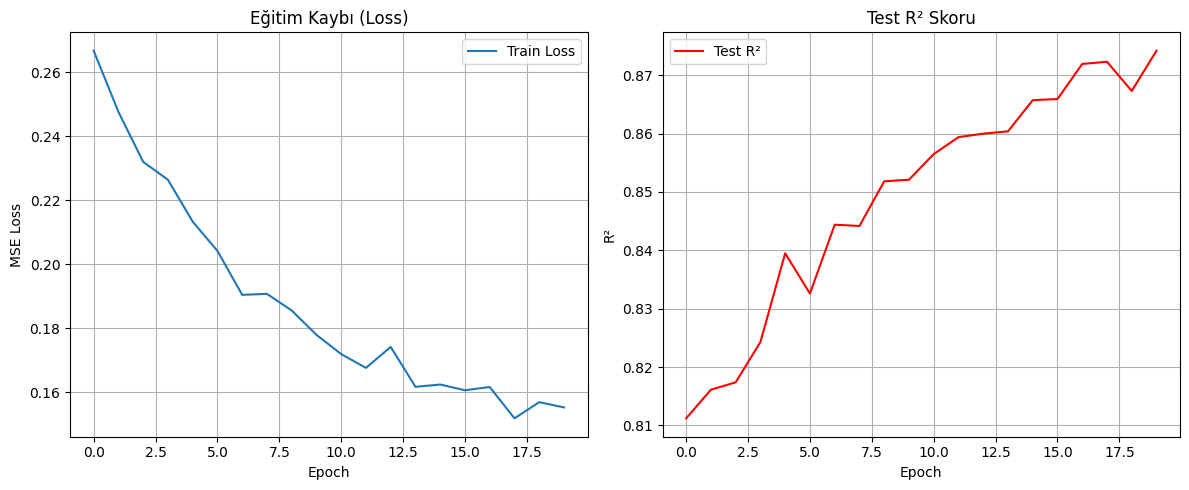

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 🔹 Eğitim kaybı (Loss)
axs[0].plot(train_loss, label="Train Loss")
axs[0].set_title("Eğitim Kaybı (Loss)")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("MSE Loss")
axs[0].legend()
axs[0].grid(True)

# 🔹 Test R²
axs[1].plot(test_r2, label="Test R²", color="red")
axs[1].set_title("Test R² Skoru")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("R²")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
